In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download the data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/project/NLP_project/songs/melon_re.csv')

df['title'].nunique(), df['lylic'].nunique()
df.drop_duplicates(subset=['lylic'], inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

df

,title,lylic
0,사랑할 수조차 없는 너인데,모든게 변했어 우리 많은게 달라져 있어 어느새 이렇게 된거니 바라만 봐도 좋...
1,네가 좋아,난 우리의 첫인사를 아직 기억해 더 많은 대화를 할 수 없을까 머뭇거렸지 ...
2,똑같은 말만,점점 멀어져가 하루에도 몇번씩이나 떠나가 흐려진 추억속에 나혼자 살아서 그리...
3,땡큐 쏘 머치 (Feat. 순이),네가 고맙다고 내게 말할 때 땡큐쏘머치 네 드레스가 예쁘다고 말하면 한번 입어...
4,열 두글자 (Feat. 한을),비 내리는 어두운 새벽 골목길 아 래서 모두가 눈물로 지새우는 밤 구름없는 하...
...,...,...
2965,새벽까지도 (feat. 루피나),하루가 어떻게 가는지도 모르겠어 난 그냥 살아간다 모든게 만족스럽지 않아 사...
2966,엄지와 검지 사랑 (feat. 다혜송),그 언젠가 꽃처럼 수줍게 나비처럼 살며시 내게로 다가와 손을 꼭 잡아주던 나...
2967,이별증후군,나 이제 괜찮아 언제 적 이야긴데 그냥 오늘은 좀 입맛이 없어서 그래 지난 일...
2968,머무르듯,마음은 말처럼 쉽지 않고 생각에 머무르듯 내 이런 마음만이라도 너에게 ...


In [ ]:
path='/content/drive/MyDrive/project/NLP_project/songs/전처리_노래제목&가사(벅스).csv'

import pandas as pd

df = pd.read_csv(path)

df['title'].nunique(), df['lylic'].nunique()
df.drop_duplicates(subset=['lylic'], inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

df

,Unnamed: 0,title,lylic
0,0,천만분의 1의 확률의 너,Every seconds Every minutes 너를 만나기 위해 모든 시간들을...
1,1,술이 뭐길래,오늘도 이렇게 어제처럼 잔을 꺼내 나 혼자서 따른 잔에 내 입술을 기대 눈물 반 ...
2,2,그때 그 순간 그대로,잘 지냈지 조금은 어색해 요즘 좋아 보여 인사 나누며 사실 궁금한 게 너무 많았는...
3,3,나의 X에게,우리 다시 만날래 예쁘게 빛나던 모든 추억들이 너무 그리워 너의 품에 안길래 이 ...
4,4,일과 이분의 일,멀리서 널 보았을 때 다른 길로 갈까 생각했는데 변한 듯한 널 보고 싶고 짧은 인...
...,...,...,...
25621,41881,뚜벅뚜벅,오늘도 뚜벅뚜벅 발길은 너무나 막연해 우리 이렇게 멀리 왔어도 느린 걸음으로 따라...
25622,41882,해피 크리스마스,혼자 있는 이 세상 빛이 없다 믿나요 기댈 곳 없어 두 뺨 위에 눈물만 힘든 발걸...
25623,41883,Stegosaurus,One two three four five It’s a pentagon One t...
25624,41884,붕붕붕 스쿨버스 안전송,헤헷 오늘도 안전하게 출발 스쿨비가 달려요 붕붕붕 붕붕붕 스쿨비가 달려요 붕붕 붕...


## Configuration


In [ ]:
batch_size = 32  # Batch size for training.
epochs = 100  # Number of epochs to train for.
hidden_units = 256  # Latent dimensionality of the encoding space.
embedding_dim = 100
num_samples = 2970  # Number of samples to train on.

## Prepare the data


데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행합니다.

1. 각 문장에 start와 end 토큰을 추가합니다.
2. 특정 문자를 제거함으로써 문장을 정리합니다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 3.9 MB/s 
     |████████████████████████████████| 453 kB 14.1 MB/s 


In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
import re
def preprocess_kor_sentence(sent):
  # 단어와 구두점 사이에 공백을 만듭니다.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  
  sent = okt.morphs(sent, stem = False)
  sent = " ".join(sent) # string으로 출력!!! 구분 " "
  return sent

In [ ]:
from tqdm import tqdm 
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    for i in tqdm(range(len(df[:num_samples]))):
        # source 데이터와 target 데이터 분리
        tar_line = df['title'].iloc[i]
        src_line = df['lylic'].iloc[i]

        # source 데이터 전처리
        src_line = [w for w in preprocess_kor_sentence(src_line).split()]

        # target 데이터 전처리
        tar_line = preprocess_kor_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋 
        tar_line_out = [w for w in (tar_line + " <eos>").split()]

        encoder_input.append(src_line)
        decoder_input.append(tar_line_in)
        decoder_target.append(tar_line_out)
                
    return encoder_input, decoder_input, decoder_target

In [ ]:
# 전처리 테스트

kr_sent = u"저녁 먹었니?"

print('전처리 전 한국어 문장 :', kr_sent)
print('전처리 후 한국어 문장 :', preprocess_kor_sentence(kr_sent))

전처리 전 한국어 문장 : 저녁 먹었니?
전처리 후 한국어 문장 : 저녁 먹었니 ?


In [ ]:
sents_lylic_in, sents_title_in, sents_title_out  = load_preprocessed_data()

100%|██████████| 2970/2970 [01:05<00:00, 45.33it/s]


In [ ]:
len(sents_lylic_in), len(sents_title_in), len(sents_title_out)

(2970, 2970, 2970)

In [ ]:
print('인코더의 입력 :',sents_lylic_in[2968])
print('디코더의 입력 :',sents_title_in[2968])
print('디코더의 레이블 :',sents_title_out[2968])

인코더의 입력 : ['마음', '은', '말', '처럼', '쉽지', '않고', '생각', '에', '머무르듯', '내', '이런', '마음', '만이라도', '너', '에게', '머무르듯', '비겁한', '마음', '일까', '네', '게', '전', '하기엔', '하지만', '진심', '이라는', '걸', '알아줬으면', '해', '들려주고', '내', '얘기', '를', '보여주고', '내', '마음', '을', '아직', '은', '모르겠지만', '언젠가', '는', '말', '야', '후회', '않을', '만큼', '너', '를', '좋아한다고', '들려주고', '내', '얘기', '를', '보여주고', '내', '마음', '을', '아직', '은', '모르겠지만', '언젠가', '는', '말', '야', '후회', '않을', '만큼', '너', '를', '좋아한다고']
디코더의 입력 : ['<sos>', '머무르듯']
디코더의 레이블 : ['머무르듯', '<eos>']


단어집합을 생성하겠습니다. 

In [ ]:
# 가사 input -> 제목 output 

# 가사 input

tokenizer_lylic = Tokenizer(filters="", lower=False)
tokenizer_lylic.fit_on_texts(sents_lylic_in)
encoder_input = tokenizer_lylic.texts_to_sequences(sents_lylic_in)

In [ ]:
# 제목 output
tokenizer_title = Tokenizer(filters="", lower=False)
tokenizer_title.fit_on_texts(sents_title_in)
tokenizer_title.fit_on_texts(sents_title_out)

decoder_input = tokenizer_title.texts_to_sequences(sents_title_in)
decoder_target = tokenizer_title.texts_to_sequences(sents_title_out)

각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다. 

In [ ]:
encoder_input = pad_sequences(encoder_input,maxlen=1500, padding="post")
decoder_input = pad_sequences(decoder_input,maxlen=8, padding="post")
decoder_target = pad_sequences(decoder_target,maxlen=8, padding="post")

In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (2970, 1500)
디코더의 입력의 크기(shape) : (2970, 8)
디코더의 레이블의 크기(shape) : (2970, 8)


샘플은 총 3833개 존재합니다


In [ ]:
src_vocab_size = len(tokenizer_lylic.word_index) +1
tar_vocab_size = len(tokenizer_title.word_index) +1

print(f"가사 단어 집합의 크기 : {src_vocab_size}, 제목 단어 집합의 크기 : {tar_vocab_size}")

가사 단어 집합의 크기 : 25300, 제목 단어 집합의 크기 : 3575


In [ ]:
len(tokenizer_title.word_index)

3574

단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다. 이들은 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용합니다. 

In [ ]:
src_to_index = tokenizer_lylic.word_index  # word : idx
index_to_src = tokenizer_lylic.index_word  # idx : word
tar_to_index = tokenizer_title.word_index # word : idx
index_to_tar = tokenizer_title.index_word # idx : word

In [ ]:
print(len(src_to_index),len(index_to_src),len(tar_to_index),len(index_to_tar))


25299 25299 3574 3574


테스트 데이터를 분리하겠습니다. 인코더 input, 디코더 input, 디코더 output이 동일하게 분리되어야 하기 때문에 랜덤한 정수배열을 만들어 직접 나누겠습니다. 

우선 랜덤하게 시퀀스를 섞습니다. 

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [1662 2774 2840 ...  913  108 2021]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
decoder_input[indices[0]], decoder_target[indices[0]]

(array([   1,  882,   35, 3097, 1028,   35,  274, 3098], dtype=int32),
 array([ 882,   35, 3097, 1028,   35,  274, 3098,    2], dtype=int32))

`<sos>` `<eos>` 토큰을 제외한 다른 단어들은 동일한 인덱스를 갖고 있어야 합니다. 

10%의 데이터를 test데이터로 분리하겠습니다. 

In [ ]:
n_of_val = int(num_samples*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (2673, 1500)
훈련 target 데이터의 크기 : (2673, 8)
훈련 target 레이블의 크기 : (2673, 8)
테스트 source 데이터의 크기 : (297, 1500)
테스트 target 데이터의 크기 : (297, 8)
테스트 target 레이블의 크기 : (297, 8)


## Model

이제 번역기를 빌드해보겠습니다. 

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

인코더를 설계합니다. LSTM에서 state_h, state_c를 리턴받는데, 이는 각각 RNN 챕터에서 LSTM을 처음 설명할 때 언급하였던 은닉 상태와 셀 상태에 해당됩니다. 이 두 가지 상태를 encoder_states에 저장합니다. encoder_states를 디코더에 전달하므로서 이 두 가지 상태 모두를 디코더로 전달할 예정입니다. 이것이 앞서 배운 컨텍스트 벡터입니다.

In [ ]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
encoder_lstm1 = LSTM(hidden_units, return_sequences = True, return_state=True)
encoder_lstm2 = LSTM(hidden_units, return_sequences = True, return_state=True)
encoder_lstm3 = LSTM(hidden_units, return_sequences = True, return_state=True)

x, eh1, ec1 = encoder_lstm1(enc_emb) # 은닉 상태와 셀 상태를 리턴
x, eh2, ec2 = encoder_lstm2(x) # 은닉 상태와 셀 상태를 리턴
encoder_outputs, eh3, ec3 = encoder_lstm3(x) # 은닉 상태와 셀 상태를 리턴

encoder_states = [eh1, ec1, eh2, ec2, eh3, ec3] # 인코더의 은닉 상태와 셀 상태를 저장

이번에는 Attention을 추가합니다. 
- Attention 중 가장 기초적인 dot-product attention을 예제로 진행하겠습니다. 
1. attention score 계산
2. softmax로 attention distribution 계산
3. 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값 계산
4. 어텐션값과 디코더의 t시점의 은닉상태를 연결
5. 출력층 연산의 입력이 되는 st 계산

디코더에서는 attention layer를 추가합니다. 
- 이때, s_는 은닉상태와 디코더의 최종 출력은 연결해야 하므로, shape을 맞춰주기 위하여 축을 추가합니다. 
- attention layer는 디코더의 은닉상태와 인코더의 은닉상태 전체를 받아 컨텍스트 벡터를 생성합니다. 
- 마지막으로 생성한 컨텍스트 벡터와 디코더의 은닉상태 전체를 softmax layer에 넣고 인덱스를 예측합니다. 


In [ ]:
from tensorflow.keras.layers import Attention

# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 임베딩 결과

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm1 = LSTM(hidden_units, return_sequences=True, return_state=True) 
decoder_lstm2 = LSTM(hidden_units, return_sequences=True, return_state=True) 
decoder_lstm3 = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
x1, h1, c1 = decoder_lstm1(dec_emb, initial_state=encoder_states[:2])
x2, h2, c2 = decoder_lstm2(x1, initial_state=encoder_states[2:4])
decoder_outputs, h3 , c3 = decoder_lstm3(x2, initial_state=encoder_states[4:])

# attention
S_ = tf.concat([eh3[:, tf.newaxis, :], decoder_outputs[:, :-1, :]], axis=1) # query 

attention = Attention(hidden_units)
context_vector, _ = attention([S_, encoder_outputs], return_attention_scores = True)

concat = tf.concat([decoder_outputs, context_vector], axis=-1)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(concat)

In [ ]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    2530000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    915200      ['input_2[0][0]']                
                                                                                              

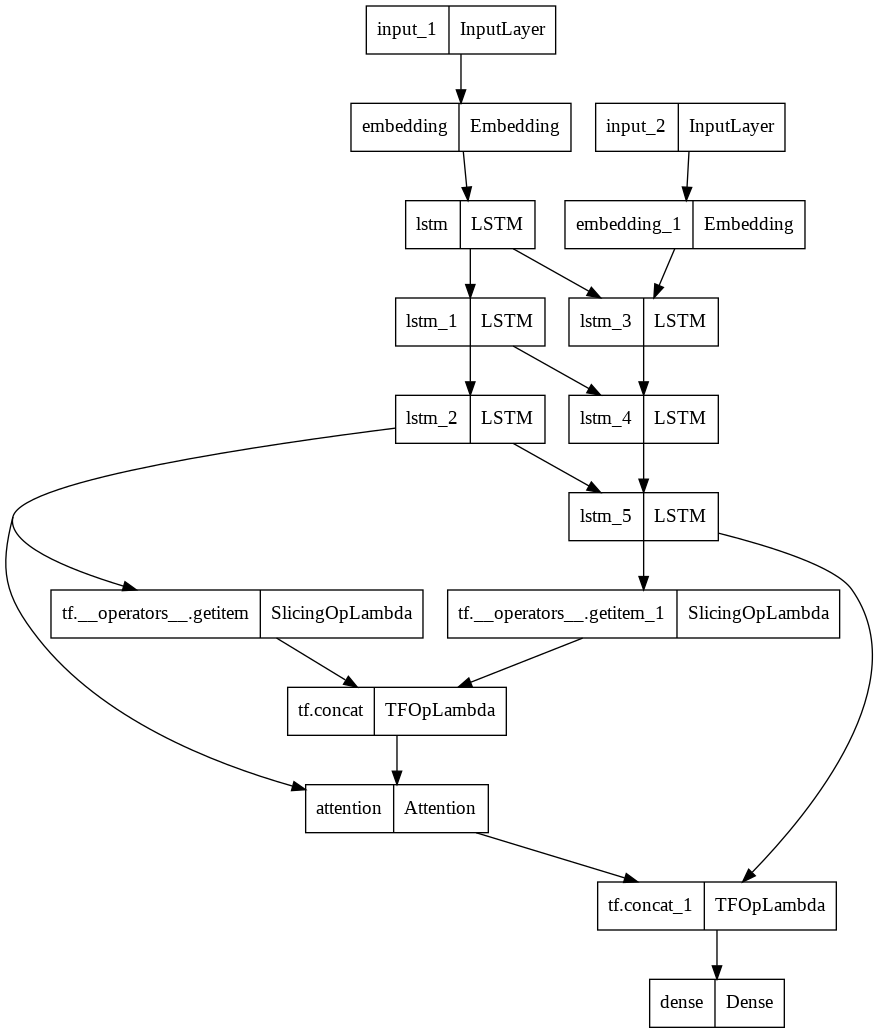

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', )

In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),batch_size=32, epochs=5)

Epoch 1/5
84/84 [==============================] - 42s 288ms/step - loss: 4.2385 - acc: 0.4459 - val_loss: 3.4484 - val_acc: 0.5758
Epoch 2/5
84/84 [==============================] - 22s 257ms/step - loss: 3.3230 - acc: 0.5539 - val_loss: 3.3815 - val_acc: 0.5779
Epoch 3/5
84/84 [==============================] - 22s 267ms/step - loss: 3.1560 - acc: 0.5663 - val_loss: 3.3812 - val_acc: 0.5888
Epoch 4/5
84/84 [==============================] - 23s 274ms/step - loss: 3.0325 - acc: 0.5728 - val_loss: 3.4091 - val_acc: 0.5833
Epoch 5/5
84/84 [==============================] - 23s 275ms/step - loss: 2.9410 - acc: 0.5749 - val_loss: 3.4340 - val_acc: 0.5829


## 훈련된 모델로 번역하기

* 평가 함수는 여기서 *교사 강요(teacher forcing)*를 사용하기 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.

    1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
    2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
    3. 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

In [ ]:
# 인코더 - 훈련과 동일 
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])

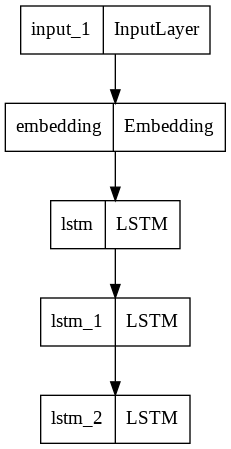

In [ ]:
tf.keras.utils.plot_model(encoder_model, to_file='model.png', )

In [ ]:
# 디코더 

# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))

decoder_state_input_h1 = Input(shape=(hidden_units,))
decoder_state_input_c1 = Input(shape=(hidden_units,))

decoder_state_input_h2 = Input(shape=(hidden_units,))
decoder_state_input_c2 = Input(shape=(hidden_units,))


decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c,
                         decoder_state_input_h1, decoder_state_input_c1,
                         decoder_state_input_h2, decoder_state_input_c2]


encoder_state_h = Input(shape=(hidden_units,))
encoder_outputs2 = Input(shape =(None, hidden_units,))


# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
x, state_h1, state_c1 = decoder_lstm1(dec_emb2, initial_state=decoder_states_inputs[:2])
x, state_h2, state_c2 = decoder_lstm2(x, initial_state=decoder_states_inputs[2:4])
decoder_outputs2, state_h3, state_c3 = decoder_lstm3(x, initial_state=decoder_states_inputs[4:])
decoder_states2 = [state_h1, state_c1, state_h2, state_c2, state_h3, state_c3]
# decoder_states2 = [state_h, state_c]

# Attention
S_ = tf.concat([encoder_state_h[:, tf.newaxis, :], decoder_outputs2[:, :-1, :]], axis=1) # query 

context_vector, att_score = attention([S_, encoder_outputs2], return_attention_scores = True)
decoder_concat = tf.concat([decoder_outputs2, context_vector], axis=-1)

# 모든 시점에 대해서 단어 예측 (Fully Connected)
decoder_outputs2 = decoder_dense(decoder_concat)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs, encoder_state_h, encoder_outputs2] + decoder_states_inputs,
    [decoder_outputs2, att_score] + decoder_states2)

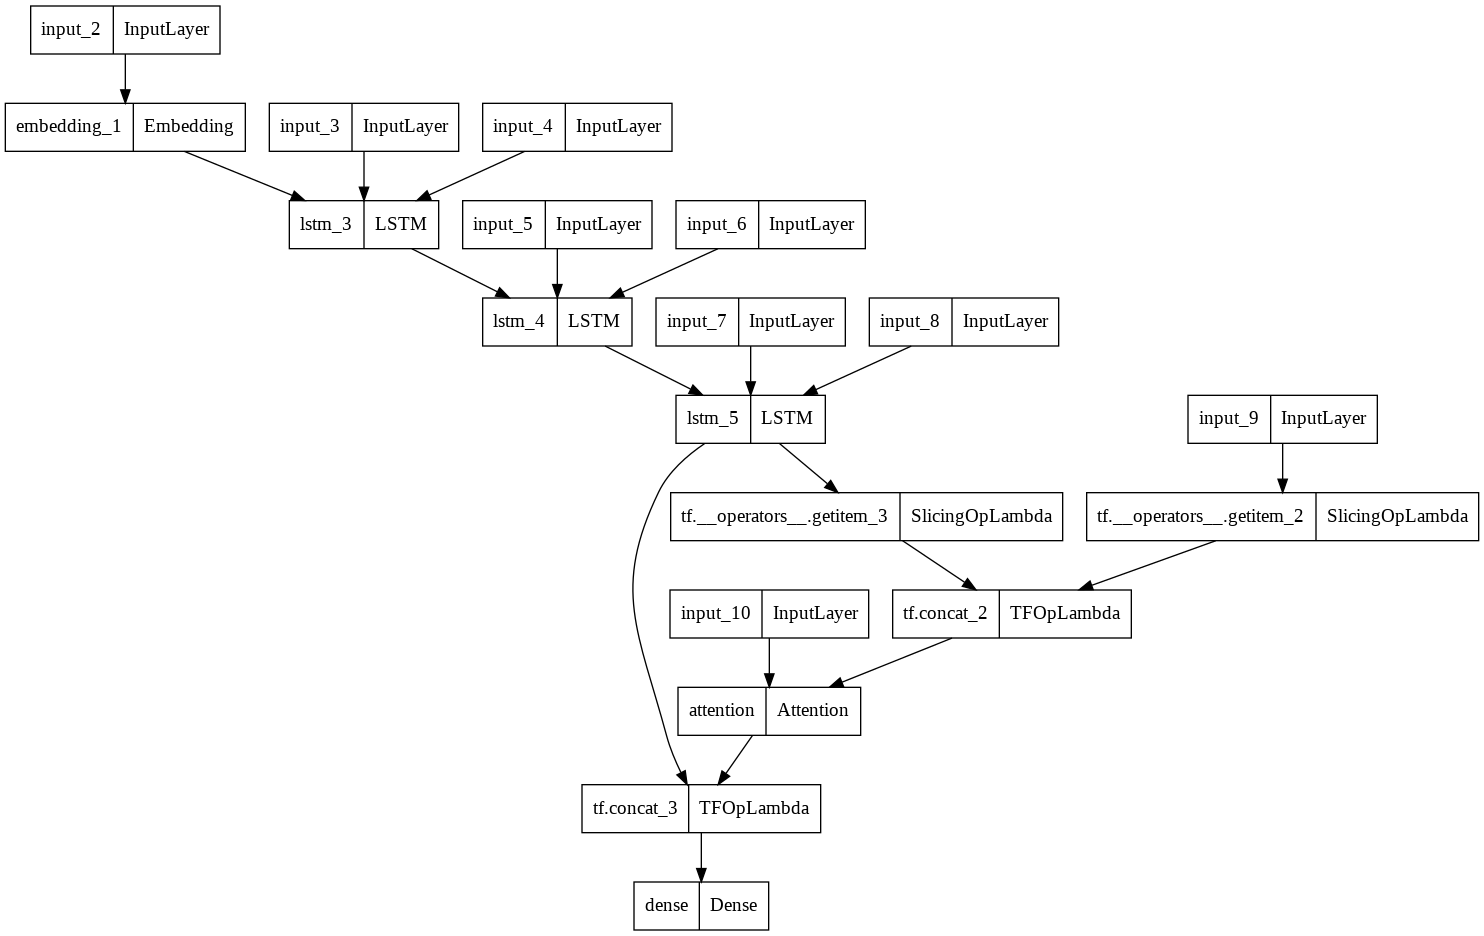

In [ ]:
tf.keras.utils.plot_model(decoder_model, to_file='model.png', )

테스트 단계에서의 동작을 위한 decode_sequence 함수를 구현합니다. 
1. 입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여 마지막 시점의 은닉 상태와 셀 상태를 리턴합니다. -> `states_value` 
2. 디코더의 초기 입력으로 <SOS>를 준비합니다. -> `target_seq`
3. 이 두 가지 입력을 가지고 while문 안으로 진입하여 이 두 가지를 디코더의 입력으로 사용합니다. 
4. 이제 디코더는 현재 시점에 대해서 예측합니다. 
    - 예측 벡터로부터 현재 시점의 예측 단어인 target_seq를 얻고, h와 c 이 두 개의 값은 states_value에 저장합니다. 
    - while문의 다음 루프. 즉, 두번째 시점의 디코더의 입력으로 다시 target_seq와 states_value를 사용합니다. 
    - 이를 현재 시점의 예측 단어로 <eos>를 예측하거나 번역 문장의 길이가 50이 넘는 순간까지 반복합니다. 
5. 각 시점마다 번역된 다어는 decoded_sentence에 누적하여 저장하였다가 최종 번역 시퀀스로 리턴합니다.

In [ ]:
def decode_sequence(sentence):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    max_src_len, max_tar_len  = encoder_input.shape[1], decoder_input.shape[1]

    attention_plot = np.zeros((max_tar_len, max_src_len))

    sentence = preprocess_kor_sentence(sentence)
    tokens = sentence.split(" ")
    inputs = tokenizer_lylic.texts_to_sequences([tokens])

    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                            maxlen=max_src_len,
                                                            padding='post')
    encoder_test, states_value = encoder_model.predict(inputs)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']
    
    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    for t in range(max_tar_len):
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, att_score, h1, c1, h2, c2, h3, c3 = decoder_model.predict([target_seq, states_value[0], encoder_test] + states_value)
        # tar_to_index 2808  

        # 어텐션 가중치 시각화를 위해 저장 
        att_score = tf.reshape(att_score, (-1, ))
        attention_plot[t] = att_score.numpy() 

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]
  
        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char


        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [ h1, c1, h2, c2, h3, c3]

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if sampled_char == '<eos>':
            break 

    return sentence, decoded_sentence, attention_plot

결과 확인을 위한 함수를 만듭니다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<eos>']):
    # if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    # you need to change the fname based on your system, and the Chinese can be displayed in the plot
    # font = FontProperties(fname=r"./data/TaipeiSansTCBeta-Regular.ttf", size=14)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation = 90)
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [ ]:
def translate(sentence):
  sentence, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

"""  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"""

"  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]\n  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"

In [ ]:
translate('번역기를 만드는 것은 재미있어.')

Input: 번역기 를 만드는 것 은 재미있어 .
Predicted translation:  사랑 의 의 <eos>


In [ ]:
translate('집에 가고 싶다.')

Input: 집 에 가고 싶다 .
Predicted translation:  사랑 의 의 <eos>


In [ ]:
translate('당신의 직업은 무엇입니까?')

Input: 당신 의 직업 은 무엇 입 니까 ?
Predicted translation:  사랑 의 의 <eos>


In [ ]:
def translate_train(seq_index):
  input_seq = encoder_input_train[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_train[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

"""  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"""

"  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]\n  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"

In [ ]:
translate_train(11)

Input: 너 를 처음 만났던 그 날 해 맑게 웃고 있는 네 가 좋았어 수많은 불빛 속 에서 그대만 보이는 그 이유 너 를 참 좋아하나 봐 하루 종일 난 너 만 생각 해 친구 와 있을 때 도 네 가 보이 고 그래 푸른 하늘 햇살 처럼 너 에게 쏟아지고 싶어 너 를 참 좋아하나 봐 너 는 별 밝게 빛나는 별 하늘 에 떠 있어 나 의 가슴 에 네 가 들어와 이 밤 이 끝나지 않길 너 만을 바라보고 싶은 이 밤 내 맘 을 감싸와 너 는 별 오직 단 한 사람 있잖아 나 는 너 로 가득해 내 시간 은 모두 네 게 다 맞춰져 있어 저 하늘 수평선 넘어 너 만의 별 이 되고 싶어 너 를 참 좋아하나 봐 Oh no no 너 는 별 밝게 빛나는 별 하늘 에 떠 있어 나 의 가슴 에 네 가 들어와 이 밤 이 끝나지 않길 너 만을 바라보고 싶은 이 밤 내 맘 을 감싸와 너 는 별 오직 단 한 사람 깊어가는 어둠 을 지나 그대 에게 닿고 싶어 너 하나 만 바 래 왔던 내 맘 을 니 가 알아주기를 Oh no 너 는 별 밝게 빛나는 별 하늘 에 떠 있어 나 의 가슴 에 네 가 들어와 이 밤 이 끝나지 않길 너 만을 바라보고 싶은 이 밤 내 맘 을 감싸와 너 는 별 오직 단 한 사람 너 는 별
Right translation : <sos> 너 는 별 
Predicted translation:  사랑 의 의 <eos>


In [ ]:

for seq_index in [10, 203, 500, 900]:
  translate_train(seq_index)
  print("-"*50)

Input: 오늘 은 비 가 와 우리 가 처음 만난 가로수길 어느 날 처럼 아직도 비 가 와 너 와의 따뜻한 추억 그대로 인데 내리는 비 와 함께 넌 떠났네 아픈 손가락 만큼 내 마음 더 아파와 비 로 눈물 을 씻어 봐도 추억 은 지워지지 않네 그렇게 비 가 온다 그렇게 비 가 간다 내 사랑 도 비처럼 오고 가는데 그렇게 비 가 온다 그렇게 비 가 간다 내 이별 노래 도 오고 가는데 오늘 은 비 가 와 마지막 버스 뒤 칸 함께 듣던 노랫말 처럼 아직도 비 가 와 너 와 듣던 노래 는 그대로 인데 내리는 비 와 함께 넌 떠났네 그렇게 비 가 온다 그렇게 비 가 간다 내 사랑 도 비처럼 오고 가는데 그렇게 비 가 온다 그렇게 비 가 간다 내 이별 노래 도 오고 가는데 비 가 온다 비 가 간다 내 사랑 도 비처럼 오고 가는데 오고 가는데 그렇게 비 가 온다 그렇게 비 가 간다 내 이별 노래 도 오고 가는데
Right translation : 온다 비 가 간다 . Prod . 하진 
Predicted translation:  사랑 의 의 <eos>
--------------------------------------------------
Input: 부디 그대 나를 잡아줘 흔들리는 나를 일으켜 제발 이 거친 파도 가 날 집어 삼키지 않게 저기 우리 함께 눈물 짓던 그때 모습 이 보여 이 젠 눈 이 부시던 날 의 기억 그래 그 순간 하나로 살 테 니 부디 다시 한번 나를 안고 제발 지친 나를 일으켜줘 우리 사랑 했었던 날 들 아직 모든 것 들 이 꿈 만 같아 부디 다시 한번 나를 깨워 제발 지친 나를 일으켜줘 다시 나 의 손 을 잡아줘 이제 잡은 두 손 을 다신 놓지 마 제발 부디 다시 한번 나를 안고 제발 지친 나를 일으켜줘 우리 사랑 했었던 날 들 아직 모든 것 들 이 꿈 만 같아 부디 다시 한번 나를 깨워줘 제발 지친 나를 일으켜줘 다시 나 의 손 을 잡아줘 부디 다시 한번 나를 안아줘 부디 다시 한번 나를 안아줘
Right translation : <sos> 부

In [ ]:
def translate_test(seq_index):
  input_seq = encoder_input_test[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_test[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: Can I tell you a secret that I ve never told I m a liar a bad bad liar So don t forgive me When we first met I told you I will always be with you I am sorry that I can t be with you no more Oh It s not your fault Oh Please don t cry You know time flies and it will take care of you So darling Things will always get better in the end Can I tell you a secret that I should never tell I love you Oh I love you so much This is my sincerity
Right translation : <sos> Summer Drink With kingo hamada 
Predicted translation:  사랑 의 의 <eos>


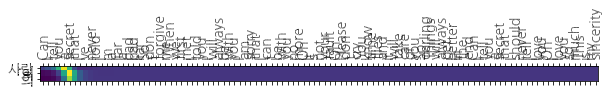

--------------------------------------------------
Input: 어지럽게 펼쳐진 사진 처럼 내 맘 도 복잡한 하루 죠 나도 내 맘 을 몰라 하루 종일 헤매죠 멍하니 난 그래요 혼자 는 자신 이 없는 날 알잖아요 사랑 했는데 정말 사랑 이었어 너 와 내 가 만든 행복한 날 들 어딜 가도 그때 의 기억 이 다 살아있는데 다시는 사랑 은 내게 없을 것 같아 결국 사랑 끝 은 상처 만 남았죠 헤어지고 이렇게 아파 할 줄 은 몰랐던 나였기에 눈물 만 나요 지금 어떻게 그대 지워 낼 수 있나요 왜 이렇게 맘 이 심난한 건지 눈물나도 그대 의 곁 이 면 다 괜찮았는데 다시는 사랑 은 내게 없을 것 같아 결국 사랑 끝 은 상처 만 남았죠 헤어지고 이렇게 아파 할 줄 은 몰랐던 나였기에 눈물 만 나요 상처 만 남겨진 우리 사랑 의 끝 이 내겐 너무 아픈 기억 이 되었어 너 로 인해 웃었던 나였었는데 이제 는 비참하게 남겨진 나라는걸
Right translation : <sos> 네 생각 이 나지 않았다고 말 했어 
Predicted translation:  사랑 의 의 <eos>


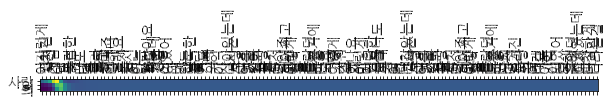

--------------------------------------------------
Input: 흰 바람 이 두 볼 에 스쳐 갈 때 떠오르는 계절 을 닮았던 사람 흩날리는 나뭇잎 이 쌓이는 거리 내 손끝 을 감싸 쥐던 한 사람 유난히 도 차갑던 나 의 가슴 에 적당한 온기 를 불어주었던 날 들 이 여지 껏 나 버텨 낸 걸음 걸음 이 되어 용기 를 내 살아갈 수 있었어 한 사람 을 사랑 하고 그 맘 을 간직 하는 건 시간 에 기대어 나를 달래는 일 문득 혼자 깨어날 때 떠오른 하나 의 이름 그리움 이 허전하게 나를 감싸오는 너 라는 날 들 스쳐 들은 노래 가 귓가 에 남아 그렇게 한참 동안 을 불러 보았나 봐 아직 고 갤 돌리면 날 바라보고 있을까 숨 죽여 흐르는 눈물 이 아팠어 한 사람 을 사랑 하고 그 맘 을 간직 하는 건 시간 에 기대어 나를 달래는 일 문득 혼자 깨어날 때 떠오른 하나 의 이름 그리움 이 허전하게 나를 감싸오는 너 라는 날 들 계절 이 더해 갈수록 더 선명한 기억 속 에서 긴 시간 을 내 가슴 에 머물러있던 한 사람 여전히 난 아직 힘들어도 사랑 해 혹시 내 가 생각나면 여기 있는 날 찾아줘 언제나 그랬던 것 처럼 웃으며 나 의 손 을 꼭 잡아줘
Right translation : <sos> 내 생 에 아름다운 
Predicted translation:  사랑 의 의 <eos>


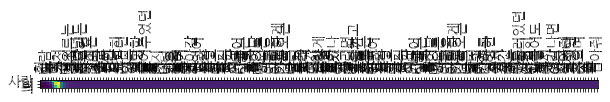

--------------------------------------------------
Input: 그래 네 가 맞았어 이 젠 편하니 이런 이별 을 바랬 니 많은 사람 들 속 에서 애써 웃어 보려 해도 너 와의 추억 들 이 점점 멀어져 만가 왜 그랬었냐고 그 이유 를 물어 도 내 가 알던 너 의 모습 은 볼수 없는데 흐려져가는 그 짧은 순간 나 의 꿈 만 같던 기억 이 멀어져만 가고있어 한 없이 너 를 그리워 하다가 쉽게 잠들지 못 해 어쩌면 다시 돌아올까봐 그래 많이 사랑 했었던 따뜻한 너 의 온기 가 그리워 눈 을 감아 봤어 널 잊어 갈 수 록 더 선명해져 만가 우리 함께 걷던 거리 에 너 를 두 고서 함께 했었던 그 소중했던 날 들 이제 서야 난 후회 돼 한 없이 너 를 그리워 하다가 쉽게 잠들지 못 해 어쩌면 너 도 그리워 할까 그래 많이 사랑 했었던 따뜻한 너 의 온기 가 그리워 눈 을 감 을 때 스스로 묻고 또 물었어 너 의 대한 기억 조차 바보 같은 내 가 싫었어 그 땐 널 아직 잊지 못 하고 되려 후회 하면서 너 의 마지막 그 미소 만 떠올라 끝없이 너 를 지워보다 가도 너 를 지우지 못 해 어쩌면 네 가 다시 나를 보며 웃을까 나 는 널 놓아 주려해 더 는 사랑 하지 않아 너 를 사랑 한 나 이제 잊어 보려해
Right translation : <sos> Traveler 
Predicted translation:  사랑 의 의 <eos>


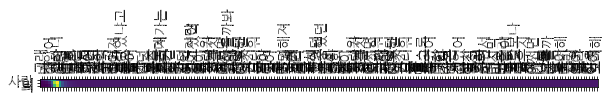

--------------------------------------------------
Input: 니 가 너무 그리워서 니 가 너무 그리워서 니 가 너무 그리워서 너 를 너 를 불러 본다 너 를 불러 본다 너 를 불러 본다 아무 기대 없이 너 만 부른다 난 미친 놈 처럼 또 너 만 찾아 부르고 있어 나를 보던 그 눈빛 이 안녕 이란 말 을 해 나를 향 한 그 눈빛 이 잘 지 내란 인사 를 해 돌아서는 너 를 보며 죽 을 것 만 같아서 그렇게 또 너 를 부른다 니 가 너무 그리워서 니 가 너무 그리워서 니 가 너무 그리워서 너 를 너 를 불러 본다 너 를 불러 본다 너 를 불러 본다 아무 기대 없이 너 만 부른다 난 미친 놈 처럼 또 너 만 찾아 부르고 있어 눈 을 뜨기 두려워져 니 가 없을테니까 눈 을 감 을 수가 없어 니 가 떠오를테니 죽 을 만큼 그리워서 죽 을 것 만 같아서 그렇게 또 너 를 부른다 니 가 너무 그리워서 니 가 너무 그리워서 니 가 너무 그리워서 너 를 너 를 불러 본다 너 를 불러 본다 너 를 불러 본다 아무 기대 없이 너 만 부른다 니 가 너무 그리워서 니 가 너무 그리워서 니 가 너무 그리워서 너 를 너 를 불러 본다 너 를 불러 본다 너 를 불러 본다 아무 기대 없이 너 만 부른다 난 미친 놈 처럼 또 너 만 찾아 부르고 있어 부르고 있어 부르고 있어 부르고 있어
Right translation : <sos> FALLIN 
Predicted translation:  사랑 의 의 <eos>


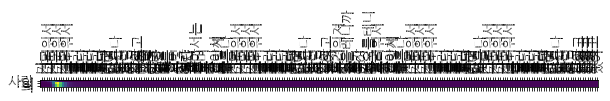

--------------------------------------------------
Input: 바람 이 불어오는 곳 그 곳 으로 가네 그대 의 머릿결 같은 나무 아래 로 덜컹이는 기차 에 기대어 너 에게 편지 를 쓴다 꿈 에 보았던 길 그 길 에 서있네 설레임 과 두려움 으로 불안한 행복 이지만 우리 가 느끼며 바라볼 하늘 과 사람 들 힘겨운 날 들 도 있지만 새로운 꿈 들 을 위해 바람 이 불어오는 곳 그 곳 으로 가네 햇살 이 눈부신 곳 그 곳 으로 가네 바람 에 내 몸 맡기고 그 곳 으로 가네 출렁이는 파도 에 흔들려도 수평선 을 바라보며 햇살 이 웃고있는 곳 그 곳 으로 가네 나뭇잎 이 손짓 하는 곳 그 곳 으로 가네 휘파람 불며 걷다가 너 를 생각 해 너 의 목소리 가 그리워도 뒤 돌아 볼 수 는 없지 바람 이 불어오는 곳 그 곳 으로 가네
Right translation : <sos> 우리 잠시 걸을까 
Predicted translation:  사랑 의 의 <eos>


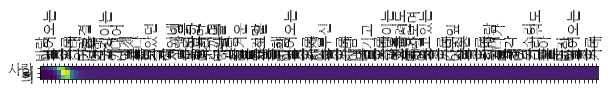

--------------------------------------------------
Input: 언제 부터 우리 가 멀어졌죠 이별 없는 사랑 이라 믿던 나 믿을 수가 없어 믿기지 않아 그냥 있어요 하루 라도 혼자 는 두지 않던 곁 에 있던 그대 가 없는 지금 한숨 만 나와요 어떻게 해야 할지 모르죠 그러지 마 요 맘 에 없는 그런 말 차가워진 그대 눈빛 이 나를 힘들게 해 요 처음 그때 로 돌아갈 수 있다면 우리 그때 로 눈물 이 자꾸 나서 아파 허탈해진 마음 을 않고 걷죠 어딜 가야 할지도 모르지만 그대 를 찾아서 헤메 고 다니는 날 아 나 요 그러지 마 요 맘 에 없는 그런 말 차가워진 그대 눈빛 이 나를 힘들게 해 요 처음 그때 로 돌아갈 수 있다면 우리 그때 로 눈물 이 자꾸 나서 아파
Right translation : 함께 해줬던 친구 들 에게 feat . 호찬 
Predicted translation:  사랑 의 의 <eos>


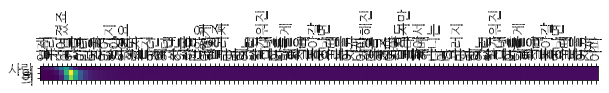

--------------------------------------------------
Input: 봄바람 이 살랑살랑 햇살 가득 따스한 날 난 눈 을 뜨면 또 너 의 생각 그렇게 조금씩 너 에게 빠졌나 봐 이런 내 맘 너 는 알까 매일 함께 하고 싶은 하루하루 깊어지는 수줍은 내 맘 을 너 에게 말 할까 가슴 이 콩닥콩닥 내 맘 이 자꾸 두근거려 눈부신 햇살 같이 빛나는 너 를 내 가 옆 에서 언제나 지켜줄게 태양 보다 더 뜨겁게 저 바다 보다 더 넓고 깊게 별빛 보다 더 빛나게 그렇게 조금씩 내 맘 이 커져가 이런 내 맘 너 는 알까 매일 함께 하고 싶은 오늘 너 를 만난다면 수줍은 내 맘 을 너 에게 말 할까 가슴 이 콩닥콩닥 내 맘 이 자꾸 두근거려 설레는 봄빛 처럼 따스한 너 를 내 가 옆 에서 언제나 함께 할게 바람 이 살랑살랑 내 맘 엔 달콤한 봄바람 이 사뿐히 내려오는 꽃잎 들 처럼 너 도 내 맘 에 그렇게 다가와 줄 래
Right translation : <sos> Blow it wind 
Predicted translation:  사랑 의 의 <eos>


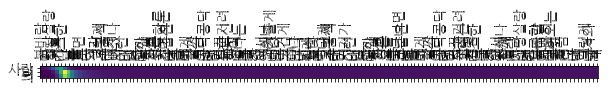

--------------------------------------------------
Input: 모든 게 다 거짓말 이야 날 보고 웃던 모습 도 날 보고 울던 모습 도 말 야 아직 다 혼란 스러워 어떤 게 네 모습 인지 정말 진심 이었는지 말 야 알 아 모든 게 망가져 비웃듯이 날 할퀴어 가면 나 그냥 돌아설까 생각 했니 끝 까지 날 속 이던 너 의 입술 을 보며 나 믿지 않게 기도 했지만 사랑 에 가려서 보이지 않아도 너 의 슬픈 눈 을 난 믿었지만 이제 는 알겠어 다 거짓말 일 뿐 인걸 모든 게 다 거짓말 이야 날 보고 웃던 모습 도 날 보고 울던 모습 도 말 야 아직 다 혼란 스러워 어떤 게 네 모습 인지 정말 진심 이었는지 말 야 알 아 모든 게 망가져 비웃듯이 날 할퀴어 가면 나 그냥 돌아설까 생각 했니 끝 까지 날 속 이던 너 의 입술 을 보며 나 믿지 않게 기도 했지만 사랑 에 가려서 보이지 않아도 너 의 슬픈 눈 을 난 믿었지만 이제 는 알겠어 다 거짓말 일 뿐 인걸
Right translation : <sos> 다짐 
Predicted translation:  사랑 의 의 <eos>


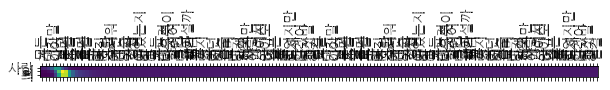

--------------------------------------------------
Input: 어떤 얘기 부터 해야 좋을지 잘 모르겠지만 잠시 만 들어 봐줘요 요즘 들어 복잡해진 일 들 로 내 가 좀 지쳤었나 봐요 아무 것 도 없던 그 시절 서로 가 서로 말곤 아무 것 도 필요 없던 어렸었던 그날 의 우리 가 그때 의 그대 가 나도 모르게 그리웠나 봐요 나도 모르게 생각 이 났었나 봐요 결코 머물지 않는 시간 속 에 하루 가 다르게 변하는 우리 는 예전 과 다르게 줄어든 둘 만의 시간 이 내 생각 에 좀 더 필요한 것 같아요 무슨 얘기 부터 해야 좋을지 잘 모르겠지만 좀 들어 봐줘요 어느샌가 반복 되는 일상 에 내 가 좀 지쳤었나 봐요 서로 작은 표정 하나 에도 하루 종일 무슨 일 있는지 궁금해하며 신경 쓰던 그날 의 우리 가 그때 의 그대 가 나도 모르게 그리웠나 봐요 나도 모르게 생각 이 났었나 봐요 결코 머물지 않는 시간 속 에 하루 가 다르게 변하는 우리 는 예전 과 다르게 줄어든 둘 만의 시간 이 내 생각 에 좀 더 필요한 것 같아요 요즘 많이 힘든 거 잘 알아요 맘 같아선 뭐 든 다 해주고 싶지만 차가운 현실 에 다른 건 몰라도 휴식 같은 사람 이 될 수 있게 내 가 내 가 노력 할게요 나도 모르게 그리웠나 봐요 나도 모르게 생각 이 났었나 봐요 결코 머물지 않는 시간 속 에 하루 가 다르게 변하는 우리 는 예전 과 다르게 줄어든 둘 만의 시간 이 내 생각 에 좀 더 필요한 것 같아요
Right translation : <sos> 널 노래 한다 
Predicted translation:  사랑 의 의 <eos>


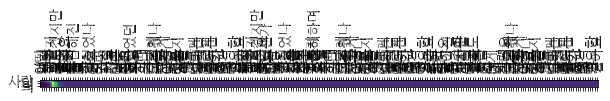

--------------------------------------------------
Input: 어린 소년 은 꿈 을 꾸었네 작은 목소리 떨리는 노래 언젠가 는 세상 사람 들 모두 내 노랠 듣게 될 거야 나 의 노래 에 같이 웃고 때론 위로 를 받던 당신 이 나를 꿈꾸게 했죠 My dream 당신 께 드립니다 소중한 나 의 그대 여 My dream 내 소중한 그대 가 있어서 나 꿈 을 꾸죠 노래 하죠 내일 을 말 하죠 My dream 나 의 노래 는 날개 가 있어서 그대 어디 있든지 들을 수 있어요 내 노래 가 당신 의 기쁨 이 되고 힘든 삶 에 작은 위로 가 되길 My dream 나 의 노래 에 같이 웃고 때론 위로 를 받던 당신 이 나를 꿈꾸게 했죠 My dream 당신 께 드립니다 소중한 나 의 그대 여 My dream 내 소중한 그대 가 있어서 나 꿈 을 꾸죠 노래 하죠 내일 을 말 하죠 My dream 나 의 노래 는 날개 가 있어서 그대 어디 있든지 들을 수 있어요 내 노래 가 당신 의 기쁨 이 되고 힘든 삶 에 작은 위로 가 되길 내 노래 가 당신 의 기쁨 이 되고 힘든 삶 에 작은 위로 가 되길 My dream
Right translation : 온다 비 가 간다 . Prod . 하진 
Predicted translation:  사랑 의 의 <eos>


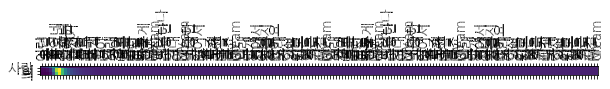

--------------------------------------------------
Input: 아무리 미워도 남아 떠나갈 것 을 모른 채 무너진 하늘 을 안고 날 깨우네 낮은 숨 을 고르며 누군가 말 을 건네어 식어 버린 차 를 내주고 들어도 모를 말 들 을 내뱉어내 멀리 있지를 않으니 아무 핑계 도 없이 날 안아주어요 늦은 잠 에 뒤척일 때 에 쥐 지 못 한 손 으로 빛 을 보여주면 눈 이 멀어 감겨 가네 그럼에도 저문 밤 을 끌어안네 얼마 큼 더 낯선 바람 이 일까 이제 메 마른 땅 은 온기 를 잃어가고 다릴 건너 시린 몸 에 머물러 미처 다 자라지 못 했지 홀로 설 수가 없으므로 미처 다 자라지 못 했지 홀로 설 수가 없으므로 그럼에도 거친 물살 에 내딛네 얼마나 더 낯선 바람 에 울까 서서히 박힌 가시 를 뽑아 내 떠돌고 헤맨 몸 을 쉬어요
Right translation : <sos> 너 는 별 
Predicted translation:  사랑 의 의 <eos>


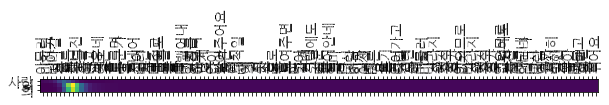

--------------------------------------------------
Input: 다 지쳤다고 생각 들 때 그대 옆 에는 내 가 있어요 다 내려놓고 싶을 때 언제 라도 좋으니 그대 내게 와요 말 하지 않아도 알아요 반짝이는 두 눈 을 바라봐요 늘 그대 옆 에 있을게요 그대 나와 두 발 을 맞춰 걸어요 모든 날 이 아름답지 못 해도 그 댄 소중한 사람 그 댄 소중한 사람 우리 함께 손 을 잡고 웃기 로 해 요 고개 를 들고 웃어요 모든 날 이 아름답지 못 해도 그 댄 소중한 사람 그 댄 소중한 사람 우리 함께 손 을 잡고 웃기 로 해 요 고개 를 들고 웃어 모든 날 이 아름답지 못 해도 그 댄 소중한 사람 그 댄 소중한 사람 우리 함께 손 을 잡고 웃기 로 해 요 환한 미소 로 웃어요
Right translation : <sos> 대답 stripped 
Predicted translation:  사랑 의 의 <eos>


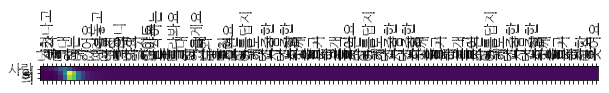

--------------------------------------------------
Input: I will cry if you 잊지 못 했는데 여전히 떠올라 미치게 슬프게 너 의 뒷모습 을 바라본 내 기억 속 늘 비친 그대 매일 떠올려 왔고 I will cry if you 너 때문 에 설렌 눈부시던 날 을 되 뇌 어 보았고 마치 처음 만 난 그때 처럼 매일 이 가슴 뛰었고 내일 이 새로웠어 네 가 떠나간 그 빈자리 에는 아무 일이 없던듯 시간 이 흘렀어 잊으려 해도 아무리 잊으려고 해봐도 넌 여기 에 Dreaming to night 너 와 같이 보낸 날 들 을 매일 떠올려 이 젠 끝났다고 말 해 주며 떠나가는 그대 모습 바라 보며 기다려 네 가 떠나간 그 빈자리 에는 아무 일이 없던듯 시간 이 흘렀어 잊으려 해도 아무리 잊으려고 해봐도 넌 여기 에 Dreaming to night 너 와 같이 보낸 날 들 을 매일 떠올려 이 젠 끝났다고 말 해 주며 떠나가는 그대 모습 바라 보며 그저 곁 에 있기만을 바라는 내 눈물 에 비친 너 의 모습 여전히난 너 의 뒤 에서 그저 울 지만 I will cry if you 잊지 못 했는데 여전히 떠올라 미치게 슬프게 너 의 뒷모습 을 바라본 내 기억 속 늘 비친 그대 매일 떠올려 왔고
Right translation : <sos> 기 억 속 에 
Predicted translation:  사랑 의 의 <eos>


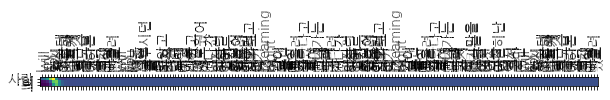

--------------------------------------------------
Input: 참 오래된 얘기 야 쉽게 버리지 못 하는 한 사람 의 습관 기억 물건 버릇 누군가 지나간 자리 엔 흔적 만이 남아 바 래 고 흠집 나고 때론 찢겨있고 어딘가 는 치료 돼있는 걸 처음 의 색 을 잃고서 작은 얼룩 이 늘어가면 그대로 두고 덮어놓을게 갈라진 틈 을 메우고 작은 상처 가 잊혀지면 그대로 두고 기억 만 해둘 게 누군가 남기고 간 것 엔 그때 의 감정 들 이 섞이고 바 래 고 흠집 나고 때론 찢겨있고 어딘가 는 치료 돼있는 걸 처음 의 색 을 잃고서 작은 얼룩 이 늘어가면 그대로 두고 덮어놓을게 갈라진 틈 을 메우고 작은 상처 가 잊혀지면 그대로 두고 기억 만 해둘 게 처음 의 색 을 잃고서 작은 얼룩 이 늘어가면 그때 는 나도 잊어버릴게 갈라진 틈 을 메우고 좋은 기억 이 늘어가면 그대로 두고 기억 만 해둘 게
Right translation : <sos> Noel For Love 
Predicted translation:  사랑 의 의 <eos>


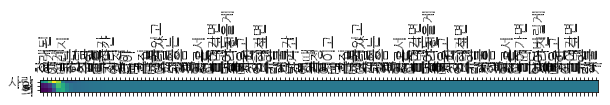

--------------------------------------------------
Input: 여기 쯤 일까 너 를 기다리던 그 곳 노란색 간판 사이 로 매일 걸어오던 곳 and I only know 어린아이 같았던 미소 시간 이 멈춘듯 했던 어느 날 의 한 장면 하고픈 말 이 많았지만 나 결국 엔 한마디 안녕 feeling 아직도 웃음 이 나 나도 모르게 니 가 보이 나 봐 fall in 나 의 오래된 memories 가장 예뻤던 그 곳 에 날 놓아줘 수 많은 날 이 지나 모든 게 변해 갔지만 난 항상 feeling 아직도 웃음 이 나 나도 모르게 니 가 보이 나 봐 fall in 나 의 오래된 memories 가장 예뻤던 그 곳 에 날 놓아줘 오래된 사진 처럼 바 래 지진 않을까 눈감으면 지금 이라도 나 의 손 에 잡힐것만 같은데 feeling 아직도 웃음 이 나 나도 모르게 니 가 보이 나 봐 fall in 나 의 오래된 memories 가장 예뻤던 그 곳 에 날 놓아줘 꽤 나 눈부셨던 그 날
Right translation : <sos> Love Me Babe ! 
Predicted translation:  사랑 의 의 <eos>


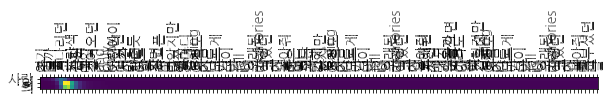

--------------------------------------------------
Input: 아름다운 땅 이 나라 에서 우리 의 꿈 을 만들어 가요 정의 와 평화 나눔 과 배려 존중 과 협력 으로 하나 되는 이 곳 에서 뚜 루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 우리 모두 가 하나 가 되어 서로 의 가치 존중 해 주고 아픈 곳 서로 위로 해 주며 가진 것 서로 나누어 봐요 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 아름다운 땅 이 나라 에서 우리 의 꿈 을 만들어가요 상식 과 법치 양심 과 헌신 소통 과 화합 으로 하나 되는 이 곳 에서 뚜 루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 우리 모두 가 두 손 맞 잡고 어려움 함께 이겨내 봐요 하나 된 우리 노력 한다면 눈부신 발전 이룰거예요 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜뚜 아름다운 땅 이 나라 에서 우리 의 꿈 을 만들어 가요 정의 와 평화 나눔 과 배려 존중 과 협력 으로 하나 되는 이 곳 에서 뚜 루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 우리 모두 가 하나 가 되어 서로 의 가치 존중 해 주고 아픈 곳 서로 위로 해 주며 가진 것 서로 나누어 봐요 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 아름다운 땅 이 나라 에서 우리 의 꿈 을 만들어가요 상식 과 법치 양심 과 헌신 소통 과 화합 으로 하나 되는 이 곳 에서 뚜 루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 우리 모두 가 두 손 맞 잡고 어려움 함께 이겨내 봐요 하나 된 우리 노력 한다면 눈부신 발전 이룰거예요 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜 뚜루뚜뚜뚜뚜
Right translation : <sos> 웃어줘요 feat . 김 가현 
Predicted translation:  사랑 의 의 <eos>


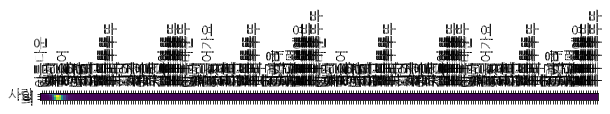

--------------------------------------------------
Input: 그 댄 어젯밤 도 선잠 에 들었나요 그대 가는 길 의 그 끝 에 서있나요 두 눈 을 감고 서 내 품 에 안겨요 다 괜찮아요 그 어떤 말로 도 표현 할 수가 없어 비 오는 날 뒤 에 한 줄기 빛 처럼 날 행복한 기억 만 전 해주는 넌 천사 인 것 같아요 나 하루 는 너 를 품 에 꼭 안고 우리 가 원했던 곳 으로 떠나 꽃 구름 에 물들 여진 빛깔 그 찬란함 속 그대 미소 가 영원히 지지 않는 밤 나 너 만을 위 한 달이 돼줄게 내 안 에서 네 가 숨 쉴 수 있게 어둠 과 외로움 은 온통 존재 하 지는 않을 거야 Cause you re my star 어떤 밤 이 와도 널 비출게 달빛 의 포근함에 잠들 수 있게 Cause you are my star Cause You are my life I m just shining on your night 나 너 를 만나 기적처럼 사랑 을 알 게 되었어 그런 네 가 울 때 면 내 모든 게 무너져 I ll give you all my light 나 너 만을 위 한 달이 돼줄게 내 안 에서 네 가 숨 쉴 수 있게 어둠 과 외로움 은 온통 존재 하 지는 않을 거야 Cause you re my star 어떤 밤 이 와도 널 비출게 달빛 의 포근함에 잠들 수 있게 Cause you are my star Cause you are my life I ll shining on your night I m just shining on your night
Right translation : <sos> 아직도 너 를 잊지 못 해 
Predicted translation:  사랑 의 의 <eos>


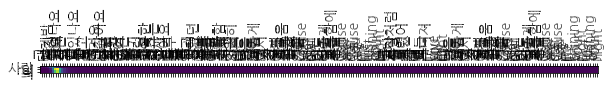

--------------------------------------------------
Input: 없죠 더 이상 그대 가 내 곁 에 있던 그대 가 함께 하겠단 약속 도 떠나지 않겠단 말 도 내 곁 에 남은 그대 흔적 은 모두 흉터 가 되어 버렸죠 몇 밤 이 지나도 몇 해 가 지나도 사라지지 않을 흉터 가 잡 을 수도 닿을 수 조차 없는 그 댄 멍 든 날 헤아려 줄 수 있을까요 소리쳐도 울부짖어도 들리지 않을 이 마음 을 그대 떠나고 나 홀로 우리 의 마지막 순간 에 멈춰 있 음 을 그 댄 알 리가 없죠 그 댄 멀어져가는 그대 를 이 젠 내 눈 에 담 을 수가 없네요 아득히 사라진 그대 를 간절히 잡아 보려 하지만 이 젠 더 이상 잡 을 수도 닿을 수 조차 없는 그 댄 멍 든 날 헤아려 줄 수 있을까요 소리쳐도 울부짖어도 들리지 않을 이 마음 을 그대 떠나고 나 홀로 우리 의 마지막 순간 에 멈춰 있 음 을 그 댄 알 리가 없죠 그 댄 알 리가 없죠 그 댄 알 수 없겠죠 이 젠 그 댄 알 리가 없죠 그 댄 정말 알 수 없겠죠 이 젠 아물어 남은 흉터 가 그대 와 같이 선명히 새겨져 있 음 을 그 댄 알 리가 없죠 그 댄 그 댄 알 수 없겠죠
Right translation : <sos> 이별 예감 
Predicted translation:  사랑 의 의 <eos>


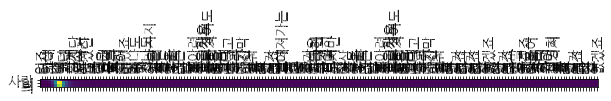

--------------------------------------------------
Input: I m always afraid to face it Seems like people hurt me and blame me Or it s just a feeling maybe Even before it starts I m worried about every ending And I know it s crazy but it s not easy to change What if I don t feel like me anymore Let me out I need to put myself first Many times I feel thankful everynight she says she loves me maybe I m blessed with all I need Settle down anywhere and take my time It s alright just never mind everything is fine It s a priority Tryna believe in me Like people round me did it It s a priority Remember the days when I was with my friends quite a lot of people used to call my name I don t know the way to express my thanks Promise that I ll make it up to you someday I m gonna make it Nobody s falling down in my place What if I don t feel like me anymore Let me out I need to put myself first Many times I feel thankful everynight she says she loves me maybe I m blessed with all I need Settle down 

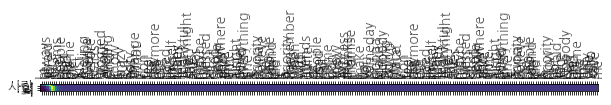

--------------------------------------------------
Input: 환상 내 가 바라본 넌 설레 이 게 하는 반짝임 낯선 내 가 겪어 본 넌 빛 의 사라짐의 그림자 칠흑 같은 한숨 도 씁쓸한 웃음 도 그저 반짝거리는 조명 에 가려진 채 고단 한 겉 치레 도 가면 속 얼굴 도 그저 반짝거리는 조명 에 가려져 보도블록 에 핀 꽃처럼 난 왜 여기 서 울 고 있을까 위태 로운 촛불 처럼 난 왜 여기 서 울 고 있을까 쉴 곳 없는 이 곳 에서 엄마 품 이 그리워 사치 라곤 꿈꿀 시간 조차 없었던 어린 시절 그 틀 을 벗어나 네 안 에서 좋은 미래 를 꿈꾸는 나 는 한없이 초라했어 단 하루 도 꿈꿀 수 없는 희 뿌연 안갯속 에 막막해져 그런 내 모습 은 언제나 너 에게 끌려 다니는 연약한 나이기에 주저앉고 싶은 나 에게 무엇 으로 채찍 질 을 해야 돼 또 일어설 수 밖에 없는 제자리걸음 막연한 환상 그래도 내 꿈 은 낮게 날아도 날 고 있다는 걸 작게 피어 도 숨 쉬 고 있다는 걸 내 눈물 견뎌 낸 다이아몬드 겉보기 보다 값진 um 내 땀방울 신비한 다이아몬드 진한 향 보다 값진 um 보도블록 에 핀 꽃처럼 난 왜 여기 서 울 고 있을까 위태 로운 촛불 처럼 난 왜 여기 서 울 고 있을까 쉴 곳 없는 이 곳 에서 엄마 품 이 그리워 환상 내 가 바라본 넌 설레 이 게 하는 반짝임 낯선 내 가 겪어 본 넌
Right translation : <sos> 나빌레 라 
Predicted translation:  사랑 의 의 <eos>


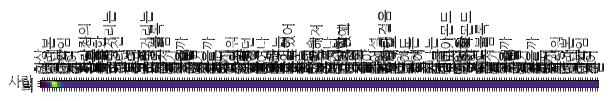

--------------------------------------------------
Input: 바람 이 지나간다 빗물 이 눈 위로 흐른다 모든 게 멈춰지고 너 와의 시간 만 남는다 바람 이 흩어진다 아무 것 도 기억 못 하게 나 에게 꽃 이었던 너 의 시간 꽃처럼 지네 찬란하고 눈 이 시리도록 눈부셨던 그 시간 은 지나고 여기 나 만 홀로 남아 너 를 기억 하네 바람 이 멈춰진다 녹음 의 시 작 점 에 길어진 그림자 가 내 발걸음 을 붙드 네 찬란하고 눈 이 시리도록 눈부셨던 그 시간 은 지나고 여기 나 만 홀로 남아 너 를 기억 하네 바람 이 지나간다 녹음 의 한 가운데 꽃 을 기억 하는 신록 이 그 자리 에서 서 있네 빗물 이 흐른다
Right translation : Sweet Dreams My Dear Song by . 소향 
Predicted translation:  사랑 의 의 <eos>


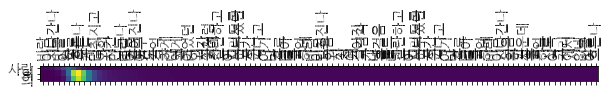

--------------------------------------------------
Input: 너무 멀어서 닿진 않지만 한 번 더 손 을 뻗어 봤죠 오늘 도 결국 달라진 건 없지만 한 번만 더 참고 뻗어 봤죠 아무 도 없고 찬 바람 부는 이 새벽 길이 또 끝나가는 내 긴 하루 의 결말 내일 은 좀 더 나은 세상 이 날 기다릴까 어제 와 똑같은 질문 을 해 요 난 괜찮을까요 괜찮아질 까요 누군가 내게 대답 좀 해줘요 어쩌면 내 가 날 슬프게 내 가 날 아프게 하고 있는 걸까 요 난 괜찮을까요 괜찮아질 까요 한 번만 날 좀 바라봐 줘요 난 괜찮을까요 사람 들 도 시간 도 나 보다 왜 이리 빠른지 헤매고 있는 건 아직 나 뿐일까 내 세상 만 이렇게 험하고 무서울까 두려움 만 더 쌓이는 것 같아 난 괜찮을까요 괜찮아질 까요 누군가 내게 대답 좀 해줘요 어쩌면 내 가 날 슬프게 내 가 날 아프게 하고 있는 걸까 요 난 지워질까 요 난 사라질까 요 이렇게 까지 아플 줄 은 난 몰랐어요 난 괜찮을까요 정말 괜찮을까요 아무 도 내게 가르쳐줄 수 없단 건 알 고 있지만 그냥 다시 물어볼래요 대답 해 줘요 바라봐 줘요 아무 말 없이 사라지지 않도록 부서지지 않도록 난 괜찮을까요 괜찮아질 까요 괜찮을 거 라고 그냥 말 이라도 해줘요 단 한 번 이라도 날 좀 바라봐 줘요 단 한 번 이라도 바라봐 줘요 나를
Right translation : <sos> 전해질 지 모를 편지 
Predicted translation:  사랑 의 의 <eos>


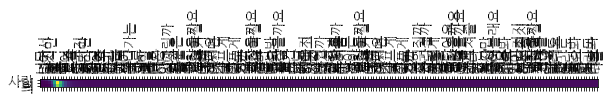

--------------------------------------------------
Input: 애써 기를 쓰며 너 에게서 멀어져 가고 있어 다신 나를 찾을 수 없을 때 까지 깊이 새긴 맘 이 조금 이라도 흔들리지 않도록 굳게 잠가놓은 채 로 다시는 널 볼 수 없는 곳 으로 모두 잊고 지내 왔던 너 를 알기 전의 나 조금씩 찾아가 보려고 해 다신 너 의 기억 에서 떠오르지 않게 널 모르는 사람 처럼 지 내 볼 게 그래 가끔 은 네 가 미치도록 그리워 질 지 몰라 네 가 전부 였던 내 삶 이 흩어져 모두 사라져 버린 것 같아 모두 잊고 지내 왔던 너 를 알기 전의 나 조금씩 찾아가 보려고 해 다신 너 의 기억 에서 떠오르지 않게 널 모르는 사람 처럼 지 내 볼 게 이제 다시 돌아오지 않기를 어떤 마음 도 남아있지 않기를 이제 서야 다 끝난 걸 알면서도 더 깊은 추억 들 이 너 를 불러 보지 만 모두 잊고 지내 왔던 너 를 알기 전의 나 조금씩 찾아가 보려고 해 혹시 너 와 마주치면 아무렇지 않게 널 스치는 사람 처럼 지 내 볼 게
Right translation : <sos> 똑똑 Tock Tock 
Predicted translation:  사랑 의 의 <eos>


KeyboardInterrupt: ignored

In [ ]:
for seq_index in range(0,2000):
  translate_test(seq_index)
  print("-"*50)

### Reference

- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://wikidocs.net/86900
- https://www.tensorflow.org/tutorials/text/nmt_with_attention?hl=ko#%ED%9B%88%EB%A0%A8%EB%90%9C_%EB%AA%A8%EB%8D%B8%EB%A1%9C_%EB%B2%88%EC%97%AD%ED%95%98%EA%B8%B0